In [6]:
import numpy as np
import pandas as pd

from os import path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [7]:
def load_and_prepare_test_site_data(data_folder_path):
    
    # Loads weather data
    raw_df_weather = pd.read_csv(path.join(data_folder_path, 'weather_test.csv'), 
                     parse_dates=['timestamp'], index_col=['site_id', 'timestamp'])
    
    # Get site list
    site_list = raw_df_weather.index.get_level_values('site_id').unique().tolist()
    prepared_site_data = {}
    
    for site in site_list:
        prepared_site_data[site] = prepare_site_data(raw_df_weather, site)
        
        
    return prepared_site_data
    

In [36]:
"""
For test set we also perform linear extrapolation (contrary to train).
"""
def prepare_site_data(weather_df, site_id):
    
    b_df_weather = weather_df.loc[(site_id,)]

    # keep only air_temperature and dew_temperature
    b_df_weather.drop(
        ['precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'cloud_coverage'],
        axis=1,
        inplace=True
    )

    # Clean timestamps index.
    clean_index = pd.date_range(start=b_df_weather.index.min(), end=b_df_weather.index.max(), freq='H')
    b_df_weather = b_df_weather.reindex(index=clean_index, copy=True)


    # Interpolate missing values.
    b_df_weather.interpolate(method='linear', limit=3, inplace=True)
    
    # Build time features
    b_df_weather['day_hour'] = b_df_weather.index.to_series().dt.hour
    b_df_weather['day_of_year'] = b_df_weather.index.to_series().dt.dayofyear
    b_df_weather['year'] = b_df_weather.index.to_series().dt.year
    
    year_0 = b_df_weather['year'].min()
    n_days_year_0 = b_df_weather[b_df_weather['year']==year_0]['day_of_year'].max()
    
    b_df_weather['day_since_0'] = b_df_weather['day_of_year'] + (b_df_weather['year']-year_0)*n_days_year_0

    b_df_weather.drop(['day_of_year', 'year'], axis=1, inplace=True)
    
    # Builds averaged weather features.

    timeframes = [24]
    features_to_avg = ['air_temperature', 'dew_temperature']
    do_center = False

    for c in features_to_avg:
        ts = b_df_weather[c]
        for timeframe in timeframes:
            shifted_ts = ts.rolling(timeframe, center=do_center).mean()
            new_col_name = '' + c + '_ma_' + str(timeframe) + 'H'
            # Extrapolate missing values (specific to test set preparation)
            extrapolated_shifted_ts = shifted_ts.interpolate(
                method='linear',
                limit_direction='backward', 
                limit_area='outside', 
                inplace=False
            )
            b_df_weather[new_col_name] = extrapolated_shifted_ts
            
            
    # Drops rows with NaNs.
    b_df_weather.dropna(axis=0, how='any', inplace=True)
            
    print('shape={}'.format(b_df_weather.shape))
        
    return b_df_weather

In [37]:
data_folder = '../data/raw/csvs/'
site_data = load_and_prepare_test_site_data(data_folder)

shape=(17520, 6)
shape=(17183, 6)
shape=(17520, 6)
shape=(17520, 6)
shape=(17519, 6)
shape=(17124, 6)
shape=(17494, 6)
shape=(16368, 6)
shape=(17520, 6)
shape=(17191, 6)
shape=(17465, 6)
shape=(16368, 6)
shape=(17184, 6)
shape=(17520, 6)
shape=(17519, 6)
shape=(16734, 6)


In [39]:
site_data[0].head()

air_temperature  dew_temperature  day_hour  day_since_0  \
2017-01-01 00:00:00             17.8             11.7         0            1   
2017-01-01 01:00:00             17.8             12.8         1            1   
2017-01-01 02:00:00             16.1             12.8         2            1   
2017-01-01 03:00:00             17.2             13.3         3            1   
2017-01-01 04:00:00             16.7             13.3         4            1   

                     air_temperature_ma_24H  dew_temperature_ma_24H  
2017-01-01 00:00:00                 18.9875               13.941667  
2017-01-01 01:00:00                 18.9875               13.941667  
2017-01-01 02:00:00                 18.9875               13.941667  
2017-01-01 03:00:00                 18.9875               13.941667  
2017-01-01 04:00:00                 18.9875               13.941667

In [69]:
def pivot_and_plot_all_sites(site_data, selected_features):
    
    n_sites = len(site_data)
    n_maps = len(selected_features)

    fig, axs = plt.subplots(nrows=n_sites, ncols=n_maps, figsize=(5*n_maps, 40*n_sites))

    # Sets nan values in red
    plt.get_cmap('Blues').set_bad('#ea0c0c')
    
    for (site_id, site_weather) in site_data.items():
        pivot_and_subplot(axs, site_id, site_weather, selected_features, n_maps)
    

In [77]:
def pivot_and_subplot(axs, row, df, selected_features, n_maps):
    
    # prepare (pivot)
    
    unindexed_df = df.reset_index(drop=True, inplace=False)

    pivoted_features = {}

    for feature in selected_features:
        df_feature_piv = unindexed_df[[feature, 'day_since_0', 'day_hour']].pivot(
            index='day_since_0', 
            columns='day_hour', 
            values=feature
        )
        pivoted_features[feature] = df_feature_piv
        
        
    # plot
    for i in range(n_maps):
        feature_i = selected_features[i]
        axs[row, i].set_title('site_' + str(row) + '\n' + feature_i)
        sns.heatmap(
            pivoted_features.get(feature_i), 
            cmap='Blues', 
            cbar_kws={"shrink": 0.1}, 
            square=True, 
            ax=axs[row, i]
        )

Let's see the data after performing pre-processing

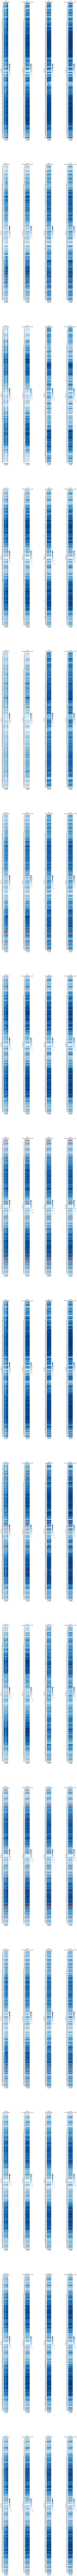

In [79]:
weather_features = [
    'air_temperature',
    'air_temperature_ma_24H',
    'dew_temperature',
    'dew_temperature_ma_24H'
]

pivot_and_plot_all_sites(site_data, weather_features)